In [1]:
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.mps 
import itertools
import csv
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

import seaborn as sns

# plt.ion() 
plt.gray()


<Figure size 640x480 with 0 Axes>

In [2]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")
    

MPS found


In [3]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        image = io.imread(img_name)
        # image = io.imread(image)
        image = Image.fromarray(image)

        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        
        return sample #return a transformed image with label


In [4]:
torch.manual_seed(17) #https://pytorch.org/vision/stable/transforms.html

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
    ]),
}

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229]),
#     ]),
#     'valid': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485], std=[0.229]),
#     ]),
# }

In [5]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [6]:
train_dataset = FERPlusDataset(csv_file= os.path.join(train_folder_path,"label.csv"), root_dir=train_folder_path, transform=data_transforms['train'])
valid_dataset = FERPlusDataset(csv_file= os.path.join(valid_folder_path, "label.csv"), root_dir= valid_folder_path, transform=data_transforms['valid'])
test_dataset = FERPlusDataset(csv_file= os.path.join(test_folder_path, "label.csv"), root_dir= test_folder_path, transform=data_transforms['valid'])

# to be changed

In [7]:
outputs_path = 'stats/outputs6'

In [8]:
def write_to_table (epochs, optimizer ,criterion, batch_size, learning_rate, activation_func, elapsed_time,train_loss, train_accuracy, valid_loss, valid_accuracy, trial_id, scheduler, device_name, dropout): 
    with open(f'{outputs_path}/statistics.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        if csvfile.tell() == 0:
            # Write the column headers
            writer.writerow(['trial', 'Batch size', 'Epochs', 'Activation function', 'Loss function', 'Initial Learning rate', 'Optimizer', 'Scheduler', 'dropout rate',
                             'Min training loss', 'Average training loss', 'Max training loss', 
                             'Min training accuracy %', 'Average training accuracy %', 'Max training accuracy %',
                             'Min validation loss', 'Average validation loss', 'Max validation loss', 
                             'Min validation accuracy %', 'Average validation accuracy %',  'Max validation accuracy %', 
                             'Total time','Device'])

        # Write the row of data
        writer.writerow([trial_id, batch_size, epochs, activation_func, criterion, learning_rate, optimizer, scheduler, dropout,
                         round(min(train_loss), 2), round(sum(train_loss) / len(train_loss), 2), round(max(train_loss), 2),
                         round(min(train_accuracy), 2), round(sum(train_accuracy) / len(train_accuracy), 2), round(max(train_accuracy), 2),
                         round(min(valid_loss), 2), round(sum(valid_loss) / len(valid_loss), 2), round(max(valid_loss), 2),
                         round(min(valid_accuracy), 2), round(sum(valid_accuracy) / len(valid_accuracy), 2), round(max(valid_accuracy), 2),
                         time.strftime('%H:%M:%S', time.gmtime(elapsed_time)), device_name])

In [9]:
def create_plot(epochs, train_accuracy, valid_accuracy, train_loss, valid_loss):      
    # Plotting the loss and accuracy
    plt.figure(figsize=(10, 5))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label='Training')
    plt.plot(range(1, epochs+1), valid_loss, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracy, label='Training')
    plt.plot(range(1, epochs+1), valid_accuracy, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

In [10]:
def output_details_to_text (model, epochs, optimizer, scheduler ,criterion, batch_size, learning_rate, id):    
    # Create a file to write the output
    filename = f'{outputs_path}/trial_details/trial_{id}'
    output_file = open(filename, "w")

    output_file.write(f"Parameter Combination: \n")
    output_file.write(f"epochs: {epochs} \n")
    output_file.write(f"initial learning_rate: {learning_rate} \n")
    output_file.write(f"batch_size: {batch_size} \n")
    output_file.write(f"optimizer: {optimizer} \n")
    output_file.write(f"scheduler: {scheduler} \n")
    output_file.write(f"criterion: {criterion} \n")
    output_file.write(f"\n")
    output_file.write(f"\n")
    output_file.write(f"architecture: {model}")
    
    output_file.write(f"Finished Training with this combination\n")
    
    output_file.write("#"*70)
    output_file.close()

In [11]:
device_name = 'MPS'

In [12]:
classes = [
    'Neutral',
    'Happinnes',
    'Surprise',
    'Sadness',
    'Anger',
    'Disgust',
    'Fear',
    'Contempt',
    'Unknown', 
    'NF'
]

In [13]:
def train_and_validate(epochs, optimizer, scheduler , criterion, model, trainloader, validloader, batch_size, learning_rate, activation_func, trial_id, device, dropout):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    predicted_labels = []
    true_labels = []
    opt_name = optimizer.__name__
    optimizer = optimizer(model.parameters(), lr=learning_rate)
        
    scheduler = scheduler(optimizer, gamma=0.9)
        
    st = time.time()

# Training - Validation loop
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        # Perform training
        for data in trainloader:
            labels = data['emotions'].to(device)
            inputs = data['image'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate and store training accuracy
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            
            total += labels.size(0)
            correct +=  (predicted == labels).sum().item()
            # print("1 more correct..")
        
        scheduler.step()
                
        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(100 * correct / total)
        
        # Perform validation
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        
        with torch.inference_mode():
            for data in validloader:
                labels = data['emotions'].to(device)
                images = data['image'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                
                total += labels.size(0)
                correct +=  (predicted == labels).sum().item() #can be torch.eq(pred, labels).sum().item()
        
                # Store predicted and true labels for calculating metrics
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        valid_loss.append(running_loss / len(validloader))
        valid_accuracy.append(100 * correct / total)

    elapsed_time = time.time() - st
    
    # Convert labels to one-hot encoding format
    # true_labels = label_binarize(true_labels, classes=list(range(10)))

    # Calculate evaluation metrics
    f1 = f1_score(true_labels, predicted_labels, average='micro')
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

    # Log evaluation metrics
    print("Evaluation Metrics:")
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Confusion Matrix:")
    print(confusion_mat)
    # sns.heatmap(confusion_mat, annot=True, cmap="Blues")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
    disp.plot()
    plt.show()
    
            
            # save the model
    # torch.save(model.state_dict(), f'./models/CNN/trial_{trial_id}.pth')     
    write_to_table(epochs, opt_name, criterion, batch_size, learning_rate, activation_func.__name__, elapsed_time, train_loss, train_accuracy, valid_loss, valid_accuracy, trial_id, scheduler.__class__.__name__, device_name, dropout)
    
    # create_plot(epochs, train_accuracy, valid_accuracy, train_loss, valid_loss)
    
    # output_details_to_text(model, epochs, optimizer, scheduler.__class__.__name__, criterion, batch_size, learning_rate, trial_id)

In [14]:
# Define parameter grids
criterions = [nn.CrossEntropyLoss()]
optimizers = [optim.SGD, optim.Adam]
activations = [F.relu, F.sigmoid]
learning_rates = [0.01]
epochs = [1]
batch_size = [32]
schedulers = [optim.lr_scheduler.ExponentialLR]
device = [torch.device("mps")]
dropout_rates = [0.1]

In [15]:
# Create all possible parameter combinations
parameter_grid = itertools.product(learning_rates, batch_size, epochs, schedulers, optimizers, activations, criterions, device, dropout_rates)

Evaluation Metrics:
F1 Score: 0.5461151481274455
Precision: 0.5461151481274455
Recall: 0.5461151481274455
Confusion Matrix:
[[1185  131   10    2    0    0    0    0    0    0]
 [ 311  561   23    4    0    0    0    0    0    0]
 [ 241   20  196    1    0    0    0    0    0    0]
 [ 315   83    9    8    0    0    0    0    0    0]
 [ 184   95   31   11    4    0    0    0    0    0]
 [  19   13    0    0    0    0    0    0    0    0]
 [  43   10   18    0    0    0    0    0    0    0]
 [  23    3    0    0    0    0    0    0    0    0]
 [  14    7    1    1    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0]]


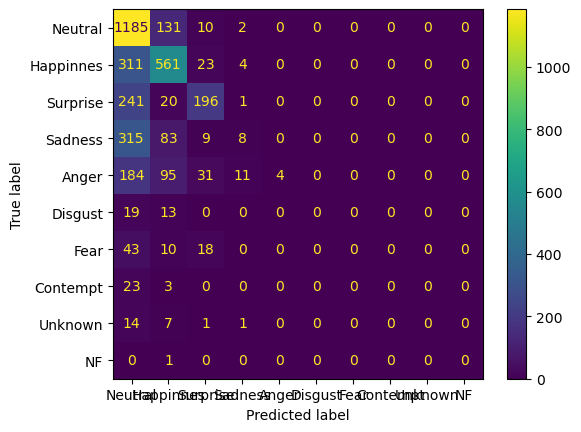

Evaluation Metrics:
F1 Score: 0.37115707098937956
Precision: 0.37115707098937956
Recall: 0.37115707098937956
Confusion Matrix:
[[1328    0    0    0    0    0    0    0    0    0]
 [ 899    0    0    0    0    0    0    0    0    0]
 [ 458    0    0    0    0    0    0    0    0    0]
 [ 415    0    0    0    0    0    0    0    0    0]
 [ 325    0    0    0    0    0    0    0    0    0]
 [  32    0    0    0    0    0    0    0    0    0]
 [  71    0    0    0    0    0    0    0    0    0]
 [  26    0    0    0    0    0    0    0    0    0]
 [  23    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0]]


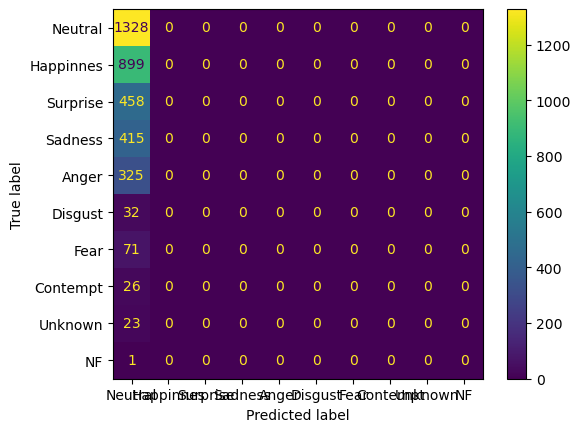

In [16]:
for i, params in enumerate(parameter_grid):
    learning_rate, batch_size, epochs, scheduler, optimizer, activation, criterion, device, dropout = params 
    # print all params
    # print(params)
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Build the CNN model with the given parameters
    class Net(nn.Module):
        def __init__(self, drop=dropout):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        # output size = 6 *44*44 values 
        # image size : n*n 
        # filter size: f*f (f is odd number)
        # shrinked_image size : (n - f + 1)^2 

            self.bn1 = nn.BatchNorm2d(6)  # Batch normalization after conv1
            
            self.pool = nn.MaxPool2d(2, 2)
        # default stride is 2 because it was not specified so defaults to kernel size which is 2
        # output size = ((n-f+1)/2)^2 = 22*22 *6  
            
            self.conv2 = nn.Conv2d(6, 16, 5)
        #output size = 18 * 18 * 16 = 5184   
            
            self.bn2 = nn.BatchNorm2d(16)  # Batch normalization after conv2
            
            self.fc1 = nn.Linear(16 * 9 * 9, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
            
            self.dropout = nn.Dropout(p=drop)
            
        def forward(self, x):
            x = self.pool(activation(self.bn1(self.conv1(x)))) 
            # 44*44*6 , 22*22*6 
            
            x = self.pool(activation(self.bn2(self.conv2(x))))
            # 18*18*16 , 9*9*16 
            
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = activation(self.dropout(self.fc1(x)))
            x = activation(self.dropout(self.fc2(x)))
            x = self.fc3(x)
            return x

    torch.manual_seed(42)
    torch.mps.manual_seed(42) 
    model = Net()
    model.to(device)
    train_and_validate(epochs, optimizer, scheduler , criterion, model, trainloader, validloader, batch_size, learning_rate, activation, i+1, device, dropout)
    
    plt.savefig(f"{outputs_path}/plots/trial_{i+1}.png")
    plt.close()
    plt.close('all')
    # make sure there is no memory leaks .. not working as expected 
    torch.mps.empty_cache()
    # clear ram
    del model
    # free memory
    import gc
    gc.collect()
    # free dataloader memory 
    del trainloader
    del validloader